In [1]:
# !pip install ../../../

In [5]:
from distributed import Client
client = Client()
client

NameError: name 'clietn' is not defined

In [14]:
# !mamba install aerobulk-python -y


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.0.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['aerobulk-python']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64 ━━━━━━━╸━━━━━━━━━━━━━━━   0.0 B /  ??.?M

In [107]:
import gcsfs
import xarray as xr
from scale_aware_air_sea.cm26_utils import load_and_combine_cm26
fs = gcsfs.GCSFileSystem()
ds = load_and_combine_cm26(fs)
ds = ds.isel(xt_ocean=slice(2000, 2350), yt_ocean=slice(1550, 1800), time=0).persist() #pre compute all the interpolation/regridding stuff as it is not relevant here

Load Data


2023-01-09 14:47:04,694 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-01-09 14:47:07,806 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-01-09 14:47:11,247 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


## Aerobulk-python demo

In [108]:
ds

<xarray.Dataset>
Dimensions:       (yt_ocean: 250, xt_ocean: 350)
Coordinates:
    time          object 0181-01-01 12:00:00
  * xt_ocean      (xt_ocean) float64 -79.95 -79.85 -79.75 ... -45.15 -45.05
  * yt_ocean      (yt_ocean) float64 29.2 29.28 29.37 ... 48.26 48.33 48.39
Data variables:
    slp           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(250, 350), meta=np.ndarray>
    v_ref         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(250, 350), meta=np.ndarray>
    u_ref         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(250, 350), meta=np.ndarray>
    t_ref         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(250, 350), meta=np.ndarray>
    q_ref         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(250, 350), meta=np.ndarray>
    wind          (yt_ocean, xt_ocean) float32 dask.array<chunksize=(250, 350), meta=np.ndarray>
    surface_temp  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(250, 350), meta=np.ndarray>
    u_ocean       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(250, 350), meta=np.ndarray>
    v_ocean       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(250, 350), meta=np.ndarray>
    u_relative    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(250, 350), meta=np.ndarray>
    v_relative    (yt_ocean, xt_ocean) float32 dask.array<chunksize=(250, 350), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [109]:
from aerobulk import noskin
ql, qh, taux, tauy, evap =  noskin(
        ds.surface_temp,
        ds.t_ref,
        ds.q_ref,
        ds.u_relative,
        ds.v_relative,
        slp=ds.slp,
        algo='ecmwf',
        zt=2,
        zu=10,
)
qh = qh.persist()

/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


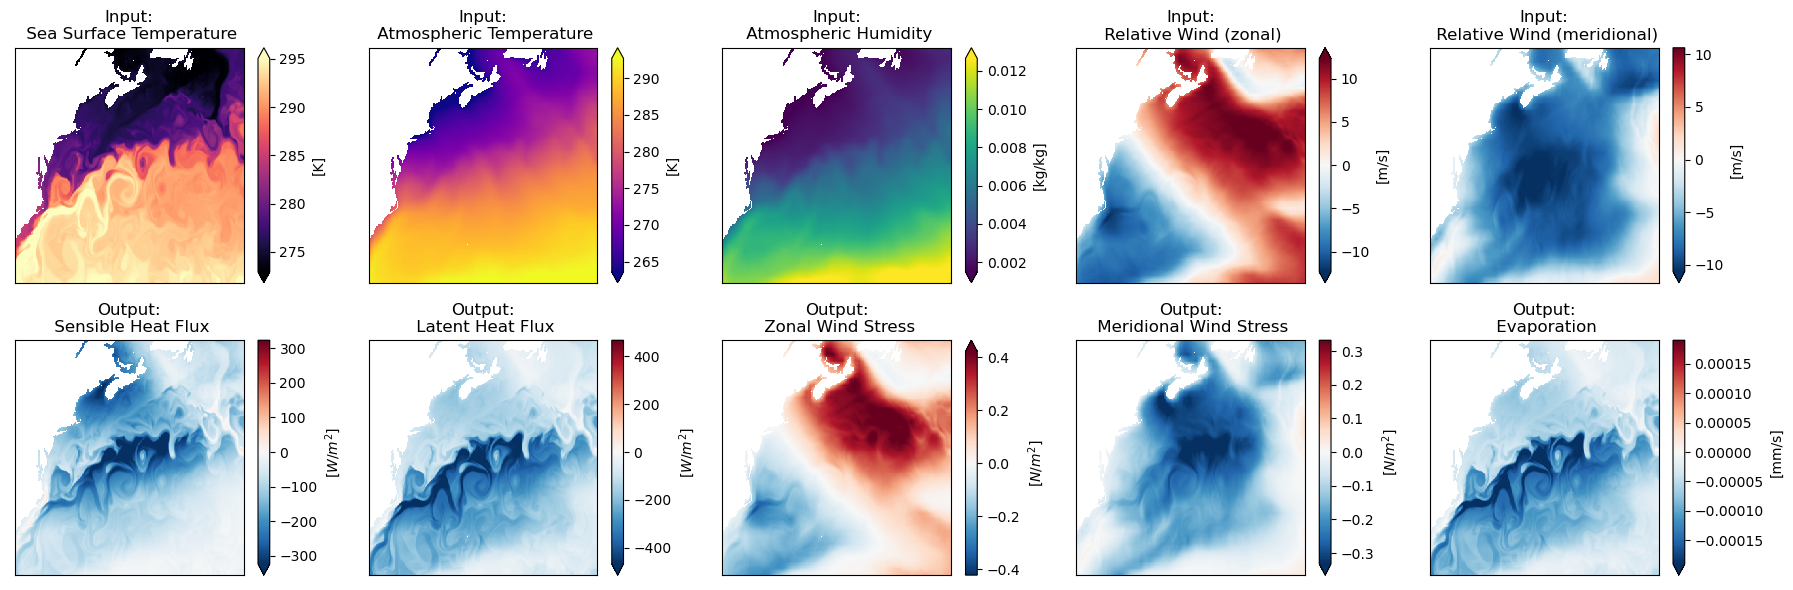

In [110]:
import matplotlib.pyplot as plt

fig, axarr = plt.subplots(nrows=2, ncols=5, figsize=[18, 6])
for i, (da_in, name, units, cmap, center) in enumerate([
    (ds.surface_temp, 'Sea Surface Temperature', "K", 'magma', None),
    (ds.t_ref, 'Atmospheric Temperature', "K", 'plasma', None),
    (ds.q_ref, 'Atmospheric Humidity', "kg/kg", 'viridis', None),
    (ds.u_relative, 'Relative Wind (zonal)', "m/s", 'RdBu_r', 0),
    (ds.v_relative, 'Relative Wind (meridional)', "m/s", 'RdBu_r', 0)]
):
    ax = axarr[0,i]
    da_in.plot(ax=ax, robust=True, cmap=cmap, cbar_kwargs={'label':f'[{units}]'})
    ax.set_title(f"Input:\n {name}")
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    
for ii, (da_out, name, units, cmap, center) in enumerate([
    (qh, 'Sensible Heat Flux', "$W/m^2$", "RdBu_r", 0),
    (ql, 'Latent Heat Flux', "$W/m^2$", "RdBu_r", 0),
    (taux, 'Zonal Wind Stress', "$N/m^2$", "RdBu_r", 0),
    (tauy, 'Meridional Wind Stress', "$N/m^2$", "RdBu_r", 0),
    (evap, 'Evaporation', "mm/s", "RdBu_r", 0),
]):
    ax = axarr[1,ii]
    da_out.plot(ax=ax, robust=True, cmap=cmap, center=center,  cbar_kwargs={'label':f'[{units}]'})
    ax.set_title(f"Output:\n {name}")
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()